In [1]:
# pip install -U shapely pyproj rtree pyogrio geopandas osmnx

import seaborn as sns
import os
import math
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

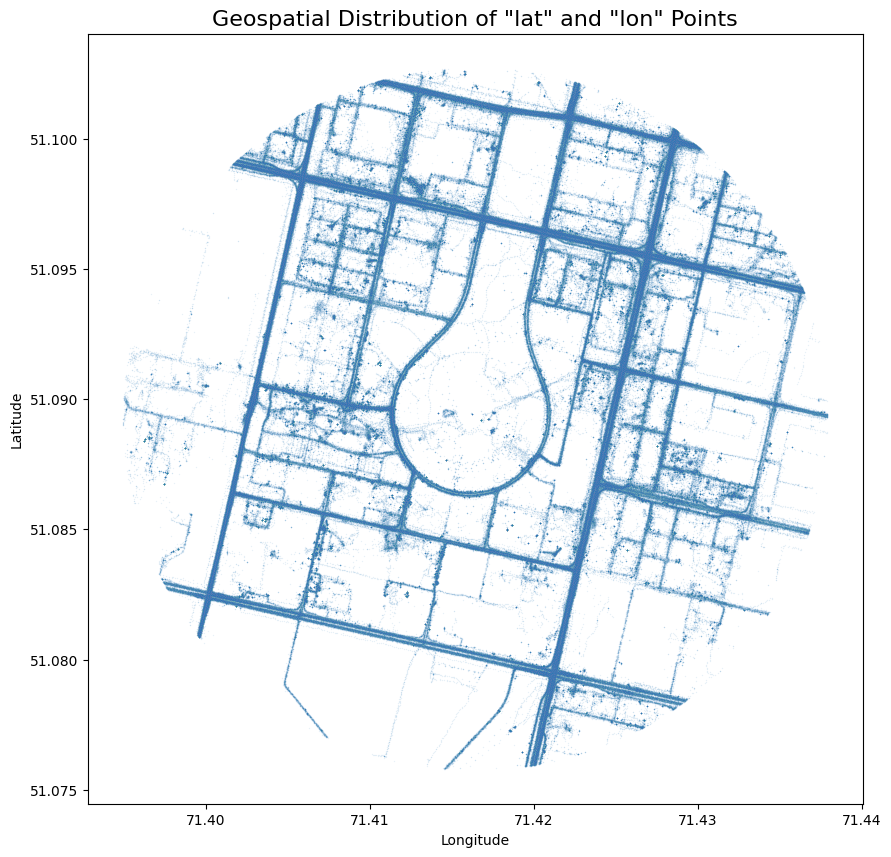

In [4]:
df = pd.read_csv("geo_locations_astana_hackathon.csv")
sample_df = df.sample(n=1262687, random_state=42) if len(df) > 50000 else df

plt.figure(figsize=(10, 10))
sns.scatterplot(x='lng', y='lat', data=sample_df, s=1, alpha=0.1)
plt.title('Geospatial Distribution of "lat" and "lon" Points', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Убираем точки вне дорог, чтобы сохранить только поездки по проезжим участкам и убрать лишний шум в виде пеших маршрутов и т.п.

In [5]:
KEEP_HIGHWAYS = (
    "motorway", "trunk", "primary", "secondary", "tertiary",
    "residential", "unclassified", "service", "living_street"
)

def _project_gdf(gdf: gpd.GeoDataFrame, to_crs=None) -> gpd.GeoDataFrame:
    """Совместимость с разными версиями OSMnx."""
    try:
        return ox.project_gdf(gdf, to_crs=to_crs)
    except AttributeError:
        from osmnx.projection import project_gdf
        return project_gdf(gdf, to_crs=to_crs)

def _get_edges_from_point(lat0: float, lon0: float, dist_m: int) -> gpd.GeoDataFrame:
    """Дороги вокруг точки (радиус dist_m), только для автосети."""
    try:
        G = ox.graph_from_point((lat0, lon0), dist=dist_m, network_type="drive", simplify=True)
    except TypeError:
        G = ox.graph_from_point((lat0, lon0), dist=dist_m, network_type="drive")
    edges = ox.graph_to_gdfs(G, nodes=False)
    if edges.empty or "highway" not in edges.columns:
        return edges.iloc[0:0].copy()

    def _has_kept(h):
        s = str(h)
        return any(cls in s for cls in KEEP_HIGHWAYS)
    edges = edges[edges["highway"].apply(_has_kept)].copy()
    return edges

def _get_buildings_from_point(lat0: float, lon0: float, dist_m: int) -> gpd.GeoDataFrame:
    """Здания как полигоны вокруг точки (радиус dist_m). Без bbox!"""
    try:
        bld = ox.features_from_point((lat0, lon0), dist=dist_m, tags={"building": True})
    except Exception:
        bld = ox.geometries_from_point((lat0, lon0), dist=dist_m, tags={"building": True})

    if bld.empty:
        return bld.iloc[0:0].copy()

    bld = bld[["geometry"]].copy()
    bld = bld[~bld.geometry.is_empty & bld.geometry.notnull()]
    bld = bld[bld.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]
    return bld

def _buf_width_for_highway(h, base=12.0):
    """Ширина буфера (м) по классу дороги."""
    s = str(h)
    if "motorway" in s or "trunk" in s: return max(base, 20)
    if "primary"  in s:                 return max(base, 14)
    if "secondary" in s:                return max(base, 12)
    if "tertiary" in s:                 return max(base, 10)
    return max(base, 8)

def _mask_intersects_union(gdf_m: gpd.GeoDataFrame, union_geom, chunk_size: int) -> pd.Series:
    """Векторное пересечение точек с union-полигоном батчами (экономит память)."""
    mask = pd.Series(False, index=gdf_m.index)
    n = len(gdf_m)
    for i in range(0, n, chunk_size):
        j = min(i + chunk_size, n)
        mask.iloc[i:j] = gdf_m.geometry.iloc[i:j].intersects(union_geom).values
    return mask

def _mask_within_union(gdf_m: gpd.GeoDataFrame, union_geom, chunk_size: int) -> pd.Series:
    """Проверка 'точка внутри зданий' батчами."""
    mask = pd.Series(False, index=gdf_m.index)
    n = len(gdf_m)
    for i in range(0, n, chunk_size):
        j = min(i + chunk_size, n)
        mask.iloc[i:j] = gdf_m.geometry.iloc[i:j].within(union_geom).values
    return mask

def save_osm_cache(edges_m: gpd.GeoDataFrame, bld_m: gpd.GeoDataFrame,
                   edges_path: str, bld_path: str | None = None):
    """Сохранить кэш .gpkg."""
    edges_m.to_file(edges_path, layer="edges", driver="GPKG")
    if bld_path and (bld_m is not None) and (not bld_m.empty):
        bld_m.to_file(bld_path, layer="bld", driver="GPKG")

def load_osm_cache(edges_path: str, bld_path: str | None = None):
    """Загрузить кэш .gpkg."""
    edges_m = gpd.read_file(edges_path, layer="edges")
    bld_m = None
    if bld_path and os.path.exists(bld_path):
        bld_m = gpd.read_file(bld_path, layer="bld")
    return edges_m, bld_m

def build_osm_cache_from_point(lat0: float, lon0: float, dist_m: int,
                               edges_path: str, bld_path: str | None = None) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame | None]:
    """Скачать дороги/здания вокруг точки и сохранить в кэш."""
    edges = _get_edges_from_point(lat0, lon0, dist_m)
    if edges.empty:
        raise RuntimeError("Не удалось получить дороги от OSM в заданном радиусе.")

    bld = _get_buildings_from_point(lat0, lon0, dist_m)

    edges_m = _project_gdf(edges)
    bld_m = _project_gdf(bld, to_crs=edges_m.crs) if (bld is not None and not bld.empty) else None

    save_osm_cache(edges_m, bld_m if bld_m is not None else gpd.GeoDataFrame(geometry=[]), edges_path, bld_path)
    return edges_m, bld_m

def filter_points_on_roads_point_radius(
    df: pd.DataFrame,
    lat_col: str = "lat",
    lon_col: str = "lon", 
    dist_m: int = 3000,   
    default_tol_m: float = 12.0,
    widen_by_class: bool = True,
    drop_inside_buildings: bool = True,
    chunk_size: int = 300_000,
    cache_dir: str | None = None,
    lat_center: float | None = None,
    lon_center: float | None = None
) -> gpd.GeoDataFrame:
    """
    Фильтрует точки df: оставляет лишь те, что лежат на дорогах (с допуском),
    и (опционально) исключает те, что строго внутри зданий.
    Вся геометрия берется через "точка + радиус" (никаких bbox-вызовов).
    Возвращает GeoDataFrame (WGS84) с исходными колонками.
    """
    if lon_col not in df.columns and "lng" in df.columns:
        lon_col = "lng"

    gdf_pts = gpd.GeoDataFrame(
        df.copy(),
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:4326"
    )
    if gdf_pts.empty:
        return gdf_pts

    lat0 = float(lat_center) if (lat_center is not None) else float(gdf_pts[lat_col].median())
    lon0 = float(lon_center) if (lon_center is not None) else float(gdf_pts[lon_col].median())

    edges_m = bld_m = None
    if cache_dir:
        os.makedirs(cache_dir, exist_ok=True)
        edges_path = os.path.join(cache_dir, f"edges_{lat0:.5f}_{lon0:.5f}_{dist_m}m.gpkg")
        bld_path   = os.path.join(cache_dir, f"bld_{lat0:.5f}_{lon0:.5f}_{dist_m}m.gpkg")

        if os.path.exists(edges_path) and os.path.exists(bld_path):
            edges_m, bld_m = load_osm_cache(edges_path, bld_path)
        else:
            edges_m, bld_m = build_osm_cache_from_point(lat0, lon0, dist_m, edges_path, bld_path)
    else:
        edges = _get_edges_from_point(lat0, lon0, dist_m)
        if edges.empty:
            return gdf_pts.iloc[0:0].copy()
        bld = _get_buildings_from_point(lat0, lon0, dist_m)
        edges_m = _project_gdf(edges)
        bld_m = _project_gdf(bld, to_crs=edges_m.crs) if (bld is not None and not bld.empty) else None

    pts_m = _project_gdf(gdf_pts, to_crs=edges_m.crs)

    if widen_by_class:
        edges_m["buf_m"] = edges_m["highway"].apply(lambda h: _buf_width_for_highway(h, base=default_tol_m))
    else:
        edges_m["buf_m"] = default_tol_m

    buffered = [geom.buffer(dist) for geom, dist in zip(edges_m.geometry, edges_m["buf_m"])]
    road_union = unary_union(buffered)

    mask_on_road = _mask_intersects_union(pts_m, road_union, chunk_size=chunk_size)
    kept = pts_m.loc[mask_on_road].copy()

    if drop_inside_buildings and (bld_m is not None) and (not bld_m.empty) and (not kept.empty):
        bld_union = unary_union(list(bld_m.geometry.values))
        mask_inside = _mask_within_union(kept, bld_union, chunk_size=chunk_size)
        kept = kept.loc[~mask_inside].copy()

    return kept.to_crs(4326)

if __name__ == "__main__":
    CSV_PATH = "geo_locations_astana_hackathon.csv"
    LAT_COL, LON_COL = "lat", "lon"

    df = pd.read_csv(CSV_PATH)

    EXPO_LAT = None
    EXPO_LON = None 

    gdf_on_roads = filter_points_on_roads_point_radius(
        df,
        lat_col=LAT_COL, lon_col=LON_COL,
        dist_m=3000,
        default_tol_m=12,
        drop_inside_buildings=True,
        chunk_size=300_000,
        cache_dir="osm_cache_expo",
        lat_center=EXPO_LAT,
        lon_center=EXPO_LON
    )

    result_df = pd.DataFrame(gdf_on_roads.drop(columns="geometry"))
    print(len(df), "→", len(result_df), "точек на дорогах")
    result_df.to_csv("points_on_roads.csv", index=False)


1262687 → 991925 точек на дорогах


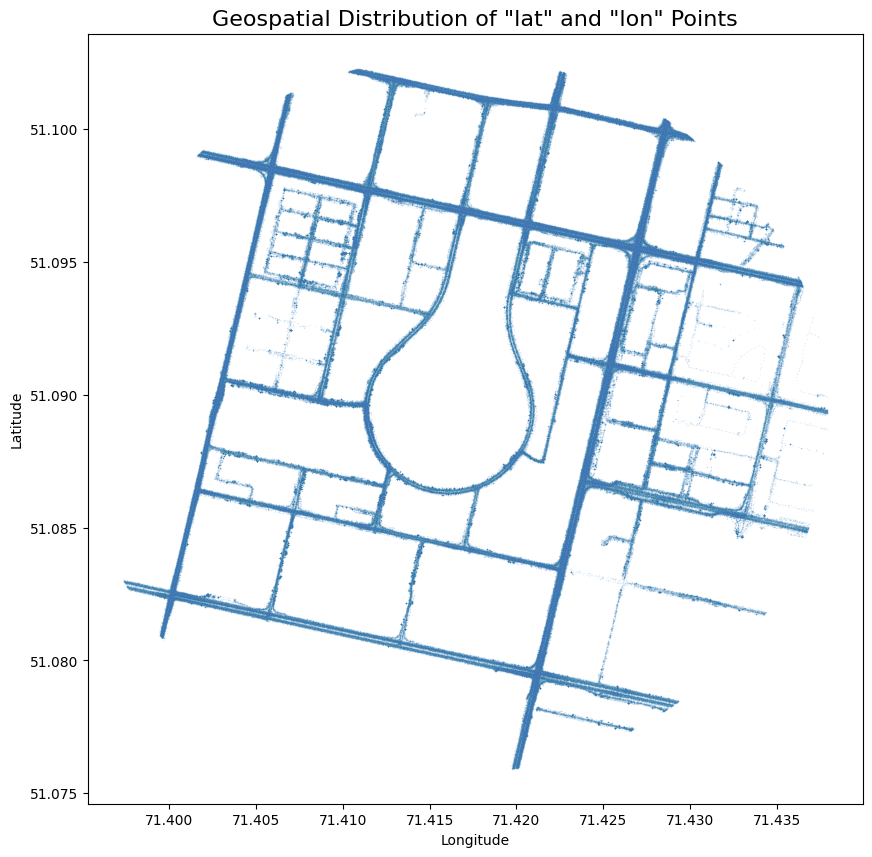

In [ ]:
TITLE = "Geospatial Distribution near EXPO (All vs On-Road)"
MAX_SAMPLE_ALL = 200_000   # чтобы не уронить ноут — сэмплим "все точки", если их очень много
MAX_SAMPLE_ROAD = 991_925  # можно больше, т.к. «на дорогах» меньше

# 1) Получаем исходные данные df
df = result_df.copy()

# определяем имена колонок долготы
lon_col = 'lon' if 'lon' in df.columns else ('lng' if 'lng' in df.columns else None)
if lon_col is None:
    raise ValueError("Не найден столбец долготы: ожидаю 'lon' или 'lng'")
lat_col = 'lat'  # по твоим данным столбец широты — 'lat'

# 2) Получаем «на дорогах» (result_df или gdf_on_roads)
on_roads_df = None
if 'result_df' in globals():
    on_roads_df = result_df.copy()
elif 'gdf_on_roads' in globals():
    try:
        # если это GeoDataFrame
        on_roads_df = pd.DataFrame(gdf_on_roads.drop(columns='geometry'))
    except Exception:
        on_roads_df = gdf_on_roads.copy()

# sanity: приводим колонки и фильтруем от NaN
df = df[[lat_col, lon_col]].dropna()
if on_roads_df is not None:
    # у on_roads_df тоже подберём правильную колонку долготы
    lon_col_r = 'lon' if 'lon' in on_roads_df.columns else ('lng' if 'lng' in on_roads_df.columns else None)
    if lon_col_r is None:
        # если вдруг там другие имена — попробуем подогнать к исходным
        lon_col_r = lon_col
        if lon_col_r not in on_roads_df.columns and 'lng' in on_roads_df.columns:
            lon_col_r = 'lng'
    on_roads_df = on_roads_df[[lat_col, lon_col_r]].dropna()
else:
    # нет отфильтрованных точек — просто покажем «все»
    lon_col_r = lon_col

# 3) Сэмплируем для скорости (без изменения распределения)
def sample_df(d, nmax):
    if len(d) > nmax:
        return d.sample(n=nmax, random_state=42)
    return d

plot_all = sample_df(df, MAX_SAMPLE_ALL)
plot_roads = sample_df(on_roads_df, MAX_SAMPLE_ROAD) if on_roads_df is not None else None

sample_df = plot_roads.sample(n=991925, random_state=42) if len(plot_roads) > 50000 else plot_roads

plt.figure(figsize=(10, 10))
sns.scatterplot(x='lng', y='lat', data=sample_df, s=1, alpha=0.1)
plt.title('Geospatial Distribution of "lat" and "lon" Points', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Переводим скорость в км/ч и убираем выбросы и невозможные значения по скорости 

In [9]:
result_df['spd_kmh']= result_df['spd'] * 3.6

Q1 = result_df['spd_kmh'].quantile(0.25)
Q3 = result_df['spd_kmh'].quantile(0.75)

IQR = Q3 - Q1

upper_threshold = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Upper threshold (Q3 + 1.5*IQR):", upper_threshold)

Q1: 10.407907390594483
Q3: 47.40306701660156
IQR: 36.99515962600708
Upper threshold (Q3 + 1.5*IQR): 102.89580645561219


In [12]:
removed = len(result_df[~((result_df['spd_kmh']<=upper_threshold)&(result_df['spd_kmh']>=0))])
result_df = result_df[(result_df['spd_kmh']<=upper_threshold)&(result_df['spd_kmh']>=0)]
print("Removed points:", removed)
print("Points left:", len(result_df))

Removed points: 0
Points left: 988933


## Убираем поездки <5  точек, т.к. скорее всего это отменившаяся поездка либо ошибочные данные

In [13]:
counts = result_df.groupby("randomized_id").size()

valid_ids = counts[counts >= 5].index

df_filtered = result_df[result_df["randomized_id"].isin(valid_ids)].copy()

removed_rows = len(result_df) - len(df_filtered)
removed_ids = counts[counts < 5].shape[0]

print(f"Removed rows: {removed_rows}")
print(f"Removed randomized_id values: {removed_ids}")

Removed rows: 834
Removed randomized_id values: 360


In [14]:
df_filtered.to_csv('clean_db.csv')

## Добавляем тип дорог для аналитики

In [15]:
KEEP_HIGHWAYS = (
    "motorway", "trunk", "primary", "secondary", "tertiary",
    "residential", "unclassified", "service", "living_street"
)

MAX_SNAP_M = 30  
HULL_BUFFER_M = 300  

def _project_gdf(gdf: gpd.GeoDataFrame, to_crs=None) -> gpd.GeoDataFrame:
    """Compatibility across osmnx versions."""
    try:
        return ox.project_gdf(gdf, to_crs=to_crs)
    except AttributeError:
        from osmnx.projection import project_gdf
        return project_gdf(gdf, to_crs=to_crs)

def _canon_highway(value):
    """
    Normalize OSM 'highway' tag to one of KEEP_HIGHWAYS.
    Handles lists and *_link variants by stripping suffix.
    Chooses the highest-priority class based on KEEP_HIGHWAYS order.
    """
    if isinstance(value, (list, tuple, set)):
        candidates = list(value)
    else:
        candidates = [value]
    normed = []
    for v in candidates:
        if v is None:
            continue
        v = str(v)
        if v.endswith("_link"):
            v = v[: -len("_link")]
        normed.append(v)

    best = None
    best_rank = 10**9
    rank = {k: i for i, k in enumerate(KEEP_HIGHWAYS)}
    for nv in normed:
        if nv in rank and rank[nv] < best_rank:
            best = nv
            best_rank = rank[nv]
    return best

def _make_custom_filter(keep=KEEP_HIGHWAYS):
    pipe = "|".join(keep)
    return f'["highway"~"{pipe}"]'

def classify_points_by_highway(
    df_filtered: pd.DataFrame,
    lat_col="lat",
    lng_col="lng",
    max_snap_m: float = MAX_SNAP_M,
    hull_buffer_m: float = HULL_BUFFER_M,
):
    """
    Returns df_filtered with:
      - 'highway_class' : one of KEEP_HIGHWAYS (or NaN if no road within max_snap_m)
      - 'distance_m'    : distance to the matched road (meters)
    """
    if df_filtered.empty:
        raise ValueError("df_filtered is empty")

    gdf_pts = gpd.GeoDataFrame(
        df_filtered.copy(),
        geometry=gpd.points_from_xy(df_filtered[lng_col], df_filtered[lat_col]),
        crs="EPSG:4326",
    )

    gdf_pts_m = _project_gdf(gdf_pts)
    hull = gdf_pts_m.unary_union.convex_hull.buffer(hull_buffer_m)
    hull_wgs = gpd.GeoSeries([hull], crs=gdf_pts_m.crs).to_crs(4326).iloc[0]

    custom = _make_custom_filter(KEEP_HIGHWAYS)
    G = ox.graph_from_polygon(
        hull_wgs,
        network_type="drive",
        simplify=True,
        retain_all=False,
        custom_filter=custom,
    )

    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
    edges = edges[edges["highway"].notna()].copy()

    edges["highway_class"] = edges["highway"].apply(_canon_highway)
    edges = edges[edges["highway_class"].isin(KEEP_HIGHWAYS)].copy()

    gdf_pts_m = _project_gdf(gdf_pts)
    edges_m = _project_gdf(edges)

    joined = gpd.sjoin_nearest(
        gdf_pts_m,
        edges_m[["geometry", "highway_class"]],
        how="left",
        max_distance=max_snap_m,
        distance_col="distance_m",
    )

    idx = joined["distance_m"].groupby(level=0).idxmin()
    joined = joined.loc[idx]

    out = pd.DataFrame(joined.drop(columns="geometry"))
    return out

result = classify_points_by_highway(df_filtered, lat_col="lat", lng_col="lng", max_snap_m=30)
result['highway_class'].value_counts(dropna=False)
result[['lat','lng','highway_class','distance_m']].head()

/var/folders/f4/jytmwzr561sg5v7fzzyyql4h0000gn/T/ipykernel_27441/3356897025.py:71: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = gdf_pts_m.unary_union.convex_hull.buffer(hull_buffer_m)


,lat,lng,highway_class,distance_m
0,51.095460,71.427530,secondary,4.987784
3,51.089779,71.428469,residential,2.603571
5,51.094540,71.407610,residential,1.481828
6,51.098690,71.405960,secondary,5.166092
7,51.100380,71.406630,secondary,0.723799


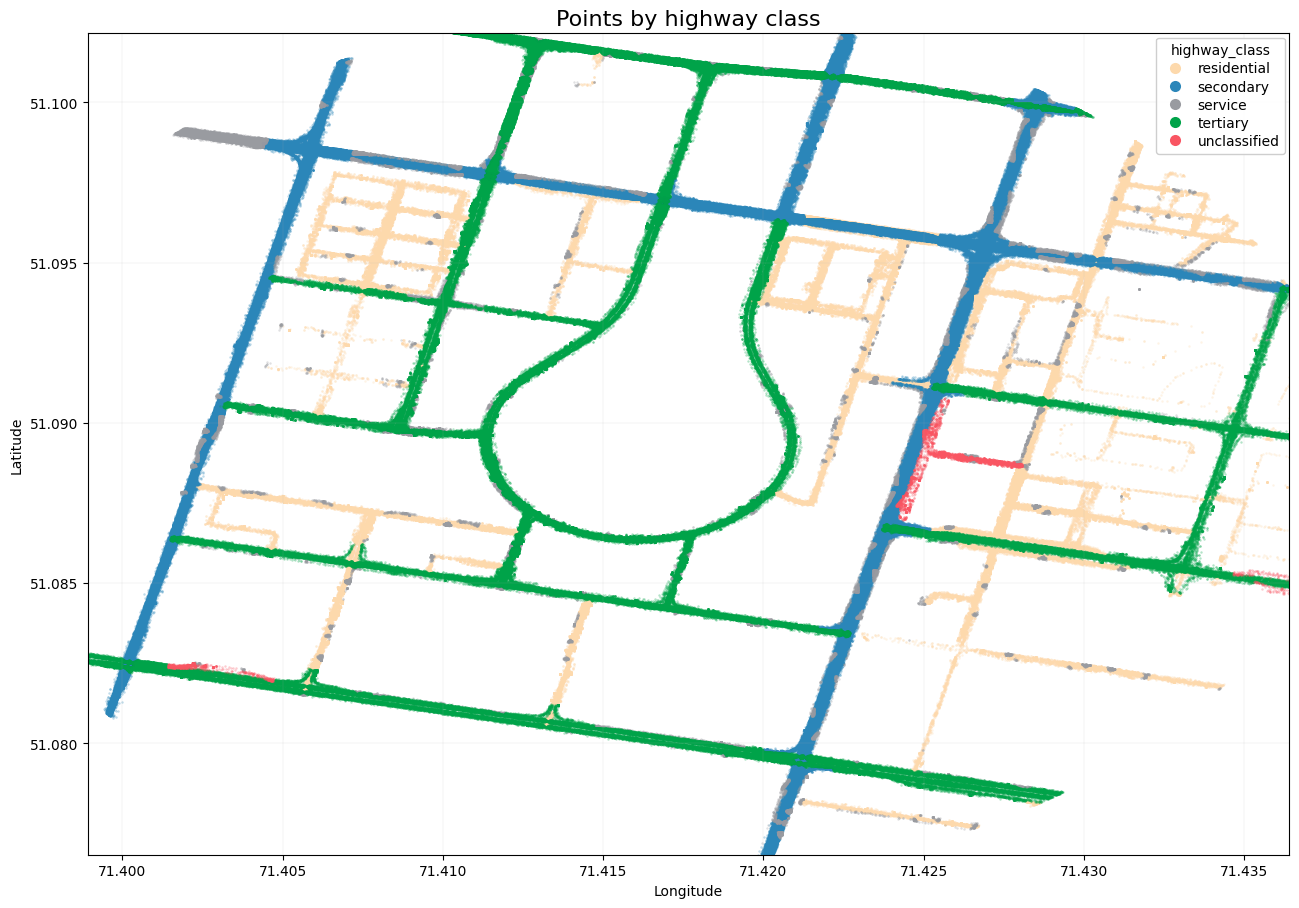

In [39]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import colorsys

# Ярче цвета (насыщение + светлоту)
PALETTE = [
    "#E5BA83", "#376C8A", "#828388", "#008A3E", "#D64550", "#37C4D7", "#375196",
    "#FAA381", "#3599B8", "#DFBFBF", "#4AC5BB", "#5F6B6D", "#FB8281", "#F4D25A",
    "#7F898A", "#A4DDEE", "#FDAB89", "#B687AC", "#28738A", "#A78F8F", "#168980",
    "#293537", "#BB4A4A", "#B59525", "#475052", "#6A9FB0", "#BD7150", "#7B4F71",
    "#1B4D5C", "#706060", "#0F5C55", "#1C2325"
]
def brighten(hex_color, sat=1.45, light=1.18):
    r, g, b = mpl.colors.to_rgb(hex_color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    s = max(0, min(1, s * sat))
    l = max(0, min(1, l * light))
    r2, g2, b2 = colorsys.hls_to_rgb(h, l, s)
    return (r2, g2, b2)

PALETTE_BRIGHT = [brighten(c) for c in PALETTE]

# 1) фильтр
sub = result.dropna(subset=["lat", "lng", "highway_class"]).copy()

# 2) conditional sampling
N, THRESH = 991_925, 50_000
sample_df = sub.sample(n=min(N, len(sub)), random_state=42) if len(sub) > THRESH else sub

# 3) цвета по классам
classes = sorted(sample_df["highway_class"].unique())
color_map = {cls: PALETTE_BRIGHT[i % len(PALETTE_BRIGHT)] for i, cls in enumerate(classes)}

# 4) робастные пределы (срежем крайние выбросы, чтобы убрать пустые поля)
q_low, q_high = 0.002, 0.998
xmin, xmax = sample_df["lng"].quantile([q_low, q_high])
ymin, ymax = sample_df["lat"].quantile([q_low, q_high])

# 5) подгоняем размер фигуры под аспект данных (меньше пустот)
dx = float(xmax - xmin)
dy = float(ymax - ymin) if (ymax > ymin) else 1.0
base = 9.0
fig_w = max(6.0, base * (dx / dy))
fig_h = base

# 6) рисуем
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
for cls, g in sample_df.groupby("highway_class", sort=True):
    ax.scatter(g["lng"], g["lat"], s=3, alpha=0.30, label=cls,
               color=color_map[cls], linewidths=0)

ax.set_title('Points by highway class', fontsize=16)
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')

# плотнее за счёт лимитов и нулевых отступов
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
ax.set_aspect('equal', adjustable='box')
ax.margins(x=0.0, y=0.0)
ax.grid(True, linewidth=0.3, alpha=0.35)

# 7) легенда внутри (непрозрачные маркеры)
legend_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor=color_map[cls], markeredgewidth=0,
           markersize=8, alpha=1.0, label=cls)
    for cls in classes
]
leg = ax.legend(
    handles=legend_handles, title="highway_class",
    loc="best", frameon=True, framealpha=0.95, borderaxespad=0.3,
    handletextpad=0.6, labelspacing=0.3
)

plt.tight_layout(pad=0.4)
plt.show()


AttributeError: 'Legend' object has no attribute 'legendHandles'

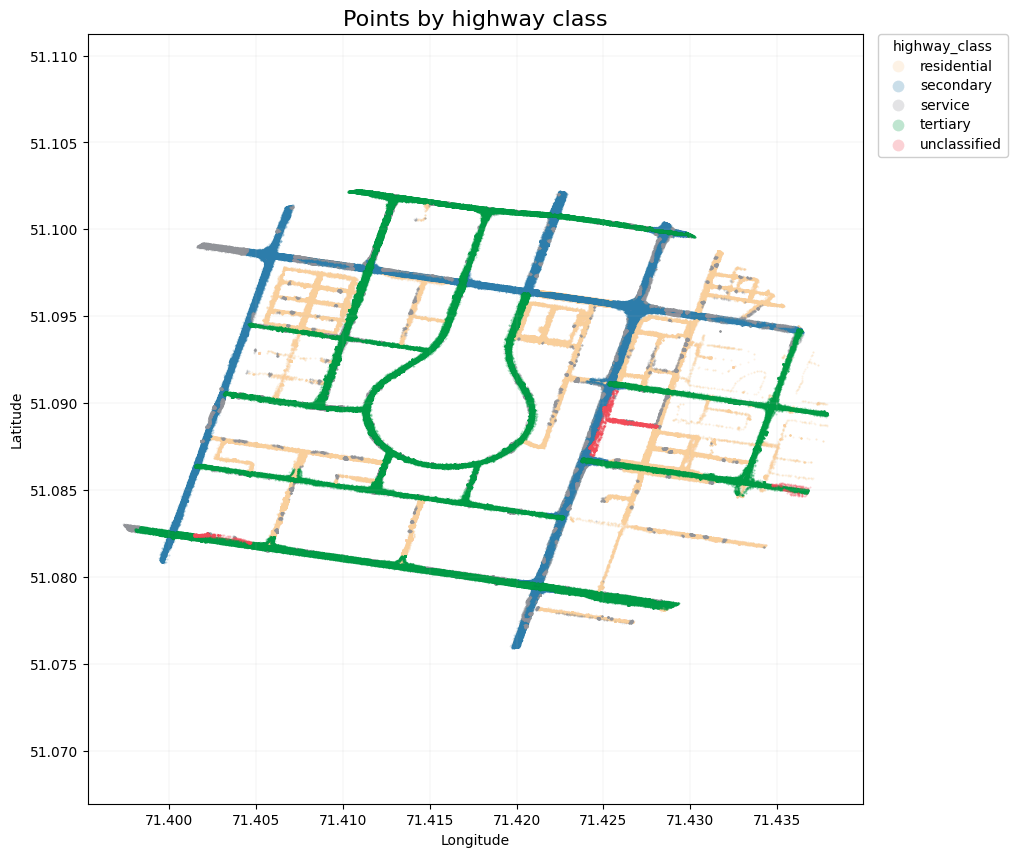

In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys

# БАЗОВАЯ ПАЛИТРА (твоя тема)
PALETTE = [
    "#E5BA83", "#376C8A", "#828388", "#008A3E", "#D64550", "#37C4D7", "#375196",
    "#FAA381", "#3599B8", "#DFBFBF", "#4AC5BB", "#5F6B6D", "#FB8281", "#F4D25A",
    "#7F898A", "#A4DDEE", "#FDAB89", "#B687AC", "#28738A", "#A78F8F", "#168980",
    "#293537", "#BB4A4A", "#B59525", "#475052", "#6A9FB0", "#BD7150", "#7B4F71",
    "#1B4D5C", "#706060", "#0F5C55", "#1C2325"
]

def brighten(hex_color, sat=1.35, light=1.12):
    """Сделать цвет насыщеннее и чуть светлее (для легенды будет читабельно)."""
    r, g, b = mpl.colors.to_rgb(hex_color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    s = max(0, min(1, s * sat))
    l = max(0, min(1, l * light))
    r2, g2, b2 = colorsys.hls_to_rgb(h, l, s)
    return (r2, g2, b2)

PALETTE_BRIGHT = [brighten(c) for c in PALETTE]

# 1) фильтр
sub = result.dropna(subset=["lat", "lng", "highway_class"]).copy()

# 2) conditional sampling
N, THRESH = 991_925, 50_000
sample_df = sub.sample(n=min(N, len(sub)), random_state=42) if len(sub) > THRESH else sub

# 3) цвета по классам (циклически по яркой палитре)
classes = sorted(sample_df["highway_class"].unique())
color_map = {cls: PALETTE_BRIGHT[i % len(PALETTE_BRIGHT)] for i, cls in enumerate(classes)}

# 4) рисуем
fig, ax = plt.subplots(figsize=(10, 10))
for cls, g in sample_df.groupby("highway_class", sort=True):
    ax.scatter(g["lng"], g["lat"], s=2, alpha=0.25, label=cls,
               color=color_map[cls], linewidths=0)

ax.set_title('Points by highway class', fontsize=16)
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.set_aspect('equal', adjustable='datalim')
ax.grid(True, linewidth=0.3, alpha=0.35)

# 5) легенда — большая, непрозрачная, читабельная
leg = ax.legend(title="highway_class", frameon=True, framealpha=0.95,
                markerscale=6, bbox_to_anchor=(1.02, 1), loc="upper left",
                borderaxespad=0, handletextpad=0.6, labelspacing=0.4)
for h in leg.legendHandles:
    if hasattr(h, "set_alpha"):
        h.set_alpha(1.0)       # полная непрозрачность в легенде
    if hasattr(h, "set_sizes"):
        h.set_sizes([30])      # крупнее маркер в легенде

plt.tight_layout()
plt.show()


In [29]:
result.drop([ 'u', 'v', 'key',  'distance_m'], axis = 1).to_csv('final_speed.csv')

## Чистим датасеты школ и камер для аналитики

In [ ]:
school_filtered = pd.read_csv('schools.csv') 

lat0, lon0 = 51.08925, 71.41642
R = 6_371_000  # радиус Земли, м

lat = np.radians(school_filtered['lat'].to_numpy())
lon = np.radians(school_filtered['lng'].to_numpy())
phi0 = np.radians(lat0)
lam0 = np.radians(lon0)

dphi = lat - phi0
dlam = lon - lam0

a = np.sin(dphi/2.0)**2 + np.cos(phi0) * np.cos(lat) * np.sin(dlam/2.0)**2
dist = 2 * R * np.arcsin(np.sqrt(a))  # расстояния в метрах

mask = dist <= 2400
schools_in_circle = school_filtered.loc[mask].copy()
schools_in_circle['dist_m'] = dist[mask]
schools_in_circle.to_csv('schools_expo.csv')

In [ ]:
cams = pd.read_csv('df_cams.csv') 

lat = np.radians(cams['lat'].to_numpy())
lon = np.radians(cams['lng'].to_numpy())
phi0 = np.radians(lat0)
lam0 = np.radians(lon0)

dphi = lat - phi0
dlam = lon - lam0

a = np.sin(dphi/2.0)**2 + np.cos(phi0) * np.cos(lat) * np.sin(dlam/2.0)**2
dist = 2 * R * np.arcsin(np.sqrt(a))  # расстояния в метрах

mask = dist <= 2400
cams_in_circle = cams.loc[mask].copy()
cams_in_circle['dist_m'] = dist[mask]
cams_in_circle.to_csv('df_cams.csv')